In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, BackupAndRestore, TerminateOnNaN
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score 
from tensorflow.keras.metrics import Precision, Recall, AUC, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, MeanSquaredError, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image   
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

2024-12-27 10:10:48.470196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735294248.516195   28437 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735294248.529004   28437 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 10:10:48.594892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!nvidia-smi

Fri Dec 27 10:10:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650        On  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              4W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Path creation

In [3]:
def number_in_dir(path):
    return len([file for file in os.listdir(path) if not file.startswith('.')])

project_path = r"/mnt/q/Projects/Pneumonia_ML-Tensorflow"
train_path = project_path + r"/chest_xray/train-gpu/"
val_path = project_path + r"/chest_xray/val/"
test_path = project_path + r"/chest_xray/test/"

train_normal_path = train_path + r'NORMAL/'
train_pneumonia_path = train_path + r'PNEUMONIA/'
train_normal_len = number_in_dir(train_normal_path)
train_pneumonia_len = number_in_dir(train_pneumonia_path)
train_sum_len = train_normal_len + train_pneumonia_len

val_normal_path = val_path + r'NORMAL/'
val_pneumonia_path = val_path + r'PNEUMONIA/'
val_normal_len = number_in_dir(val_normal_path)
val_pneumonia_len = number_in_dir(val_pneumonia_path)
val_sum_len = val_normal_len + val_pneumonia_len

test_normal_path = test_path + r'NORMAL/'
test_pneumonia_path = test_path + r'PNEUMONIA/'
test_normal_len = number_in_dir(test_normal_path)
test_pneumonia_len = number_in_dir(test_pneumonia_path)
test_sum_len = test_normal_len + test_pneumonia_len

print("[Train] Number of NORMAL Images: ", train_normal_len)
print("[Train] Number of PNEUMONIA Images: ", train_pneumonia_len)
print("[Train] Number of TOTAL Images: ", train_sum_len)

print("[Test] Number of NORMAL Images: ", test_normal_len)
print("[Test] Number of PNEUMONIA Images: ", test_pneumonia_len)
print("[Test] Number of TOTAL Images: ", test_sum_len)

print("[Validation] Number of NORMAL Images: ", val_normal_len)
print("[Validation] Number of PNEUMONIA Images: ", val_pneumonia_len)
print("[Validation] Number of TOTAL Images: ", val_sum_len)

[Train] Number of NORMAL Images:  3656
[Train] Number of PNEUMONIA Images:  11875
[Train] Number of TOTAL Images:  15531
[Test] Number of NORMAL Images:  244
[Test] Number of PNEUMONIA Images:  420
[Test] Number of TOTAL Images:  664
[Validation] Number of NORMAL Images:  617
[Validation] Number of PNEUMONIA Images:  1773
[Validation] Number of TOTAL Images:  2390


Comparing photos 

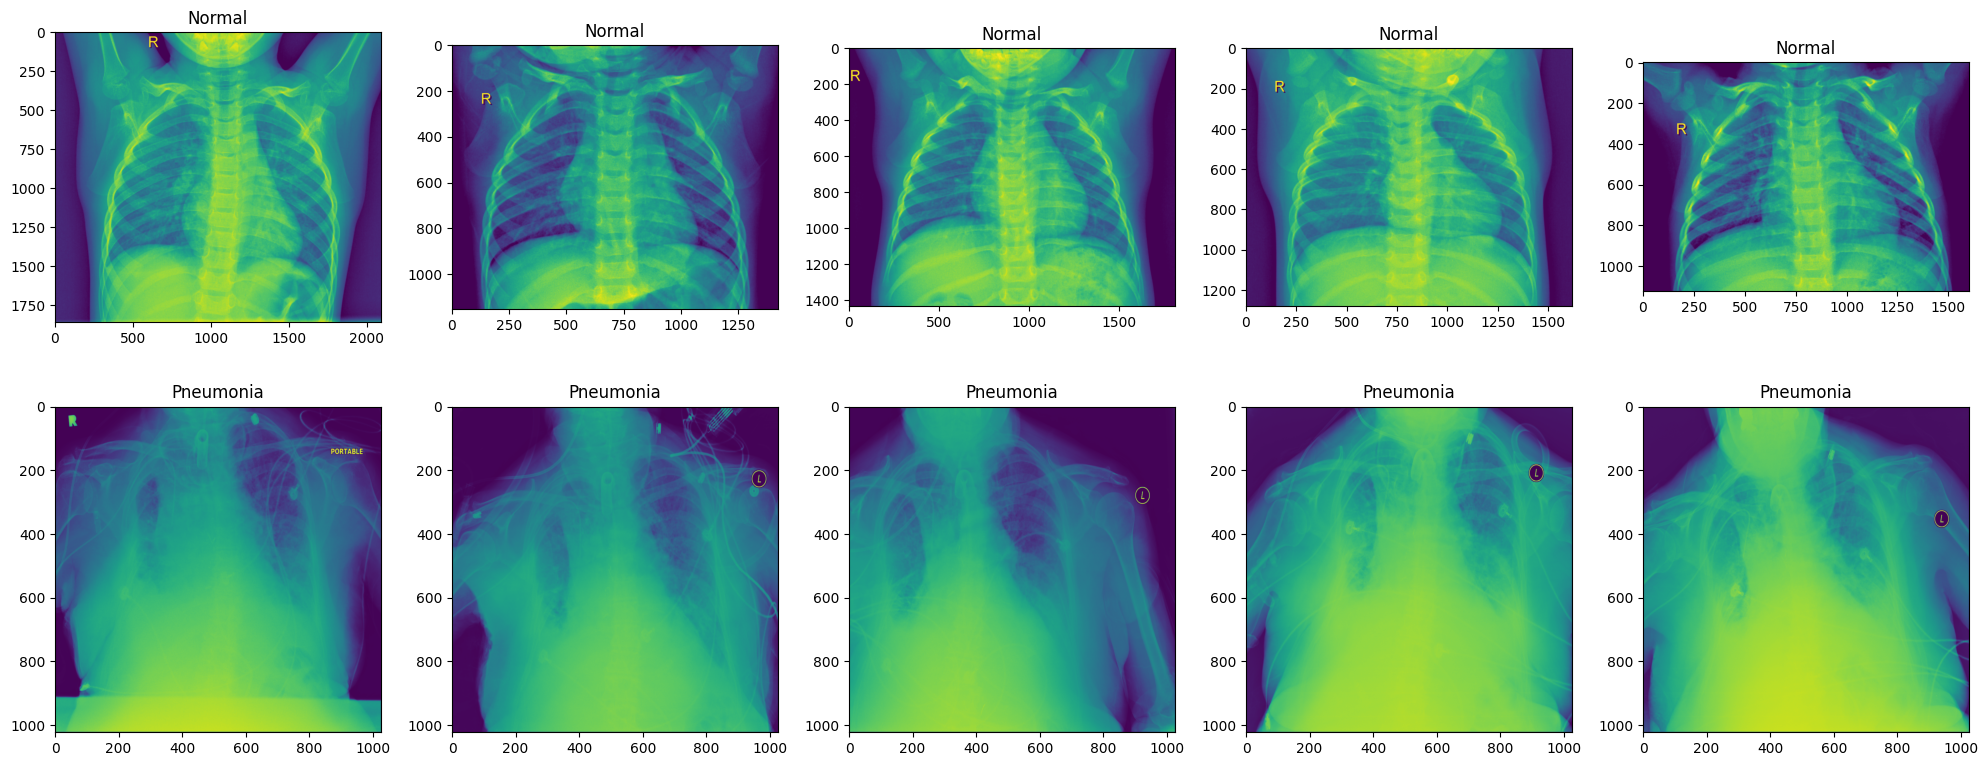

In [4]:
plt.figure(figsize=(20, 8))
num = 5
for index in range(num):
    norm_img_title = os.listdir(train_normal_path)[index]
    norm_img_path = train_normal_path + norm_img_title
    
    plt.subplot(2, num, index+1)
    plt.imshow(Image.open(norm_img_path))
    plt.title('Normal')
    
    pneum_img_title = os.listdir(train_pneumonia_path)[index]
    pneum_img_path = train_pneumonia_path + pneum_img_title
    
    plt.subplot(2, num, index+num+1)
    plt.imshow(Image.open(pneum_img_path))
    plt.title('Pneumonia')
plt.tight_layout()
plt.show()

Percentage statistic in Dataset

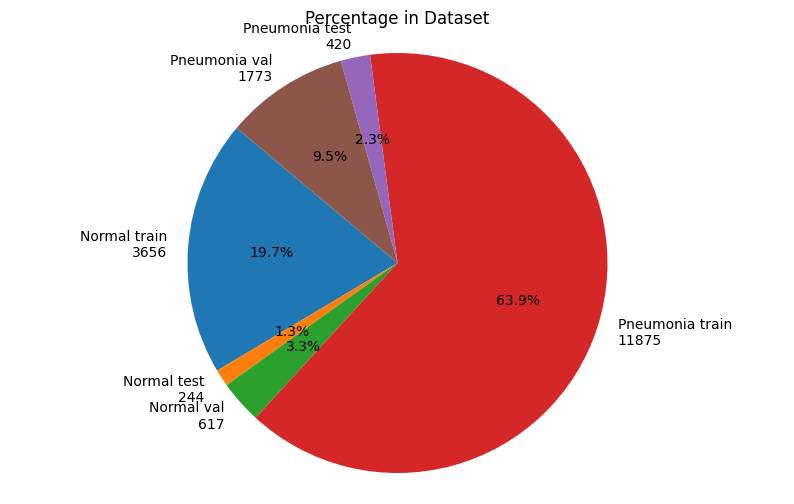

: 

: 

: 

: 

In [5]:
categories = [f'Normal train-gpu\n{train_normal_len}', f'Normal test\n{test_normal_len}', 
              f'Normal val\n{val_normal_len}', f'Pneumonia train-gpu\n{train_pneumonia_len}', 
              f'Pneumonia test\n{test_pneumonia_len}', f'Pneumonia val\n{val_pneumonia_len}']

image_counts = [train_normal_len, test_normal_len, val_normal_len, train_pneumonia_len, test_pneumonia_len, val_pneumonia_len]  
plt.figure(figsize=(10, 6))
plt.pie(image_counts, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Percentage in Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Func for creating chart

In [5]:
def create_charts(model, history, test_dataset):
    # Define train-gpu & validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Define train-gpu & validation AUC
    train_auc_name = list(history.history.keys())[3]
    val_auc_name = list(history.history.keys())[1]
    train_auc = history.history[train_auc_name]
    val_auc = history.history[val_auc_name]
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Extract true labels and make predictions
    y_true = []
    y_pred_prob = []

    # Handle tuple dataset structure (images, labels)
    for images, labels in test_dataset:
        y_true.extend(labels.numpy().flatten())
        y_pred_prob.extend(model.predict(images).flatten())

    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Check label distribution in `y_true`
    unique, counts = np.unique(y_true, return_counts=True)
    print(f"Label distribution in y_true: {dict(zip(unique, counts))}")

    # Plot
    plt.figure(figsize=(20, 18))

    # Plot 1: Train vs. Validation Loss 
    plt.subplot(3, 2, 1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss', marker='o')
    plt.plot(val_loss, label='validation loss', marker='+')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    # Plot 2: Train vs. Validation AUC
    plt.subplot(3, 2, 2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc', marker='o')
    plt.plot(val_auc, label='validation auc', marker='+')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    # Plot 3: Confusion Matrix
    plt.subplot(3, 2, 3)
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    counts = [value for value in cm.flatten()]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, percentages, counts)]
    labels = np.asarray(labels).reshape(2, 2)
    ticklabels = ['Normal', 'Pneumonia']

    # Create confusion matrix as heatmap
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14)

    # Plot 4: ROC Curve
    plt.subplot(3, 2, 4)
    if len(np.unique(y_true)) > 1:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
        auc = roc_auc_score(y_true, y_pred_prob)
        plt.title('ROC Curve')
        plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 50%)")
        plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc * 100))
        plt.xlabel('False Positive Rate', size=14)
        plt.ylabel('True Positive Rate', size=14)
        plt.legend(loc='best')
    else:
        print("ROC-AUC cannot be calculated due to lack of class variability in y_true.")

    ## PLOT 5: TRAIN VS. VALIDATION ACCURACY
    plt.subplot(3, 2, 5)
    plt.title("Training vs. Validation Accuracy")
    plt.plot(train_acc, label='training accuracy', marker='o')
    plt.plot(val_acc, label='validation accuracy', marker='+')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    # End plots
    plt.tight_layout()

    # Summary Statistics
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / np.sum(cm)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1 = 2 * precision * recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)


Model Settings 

In [11]:
dimension = 224
initial_epochs = 25
batch_size = 32

mode = 'rgb'
channels = 1 if mode == 'grayscale' else 3

total = val_sum_len + test_sum_len + train_sum_len
pos = test_pneumonia_len + train_pneumonia_len + val_pneumonia_len
neg = test_normal_len + train_normal_len + val_normal_len
# initial_bias = np.log([pos/neg])
initial_bias = 0.0
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias

def penalised_binary_crossentropy(w0, w1):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0) errors
        loss = -w1 * y_true * tf.math.log(y_pred) - w0 * (1 - y_true) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)
    return loss

# If false negatives are more critical (e.g., in medical diagnosis), set w1 > w0
# If false positives are more critical (e.g., spam filtering), set w0 > w1
# To avoid numerical instability (logarithm of 0), predictions are clipped between 1e-7 and 1-1e-7

w0 = 1.0  # Weight for false positives
w1 = 2.0  # Weight for false negatives

# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)
# 
# class_weight = {0: weight_for_0, 1: weight_for_1}
# 
# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

Image from TFrecord

In [7]:
def parse_tfrecord(serialized_example, size=(dimension, dimension), channels=channels):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    label = example['label']
    image = tf.io.decode_raw(example['image'], tf.uint8)
    image = tf.reshape(image, (*size, channels))  # Reshape to the original dimensions
    image = tf.divide(tf.cast(image, tf.float32), 255.0)  # Normalize pixel values
    return image, label

def load_tfrecord(tfrecord_file, batch_size):
    data = tf.data.TFRecordDataset(tfrecord_file)
    data = data.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    data = data.cache('./temp/dataset/').shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return data

# Example usage
train_dataset = load_tfrecord('train.tfrecord', batch_size=batch_size)
val_dataset = load_tfrecord('val.tfrecord', batch_size=batch_size)
test_dataset = load_tfrecord('test.tfrecord', batch_size=batch_size)

def check_label_distribution(dataset):
    labels = []
    for _, label in dataset.as_numpy_iterator():
        labels.extend(label)
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Label distribution: {dict(zip(unique, counts))}")
    return dict(zip(unique, counts))

print(
check_label_distribution(train_dataset),
check_label_distribution(val_dataset),
check_label_distribution(test_dataset)
)

# train_label_counts=check_label_distribution(train_dataset)
# total_samples = sum(train_label_counts.values())
# class_weights = {label: total_samples / (len(train_label_counts) * count)
#                  for label, count in train_label_counts.items()}

# print("Class Weights:", class_weights)  

I0000 00:00:1735294285.329470   28437 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
2024-12-27 10:11:37.259173: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Label distribution: {np.int64(0): np.int64(2749), np.int64(1): np.int64(8402)}


2024-12-27 10:11:46.763661: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Label distribution: {np.int64(0): np.int64(2749), np.int64(1): np.int64(8402)}
Label distribution: {np.int64(0): np.int64(2749), np.int64(1): np.int64(8402)}
{np.int64(0): np.int64(2749), np.int64(1): np.int64(8402)} {np.int64(0): np.int64(2749), np.int64(1): np.int64(8402)} {np.int64(0): np.int64(2749), np.int64(1): np.int64(8402)}


2024-12-27 10:12:10.798999: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


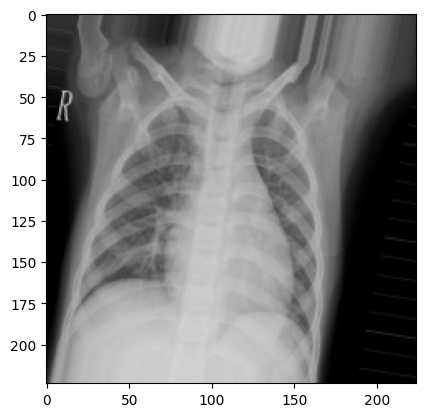

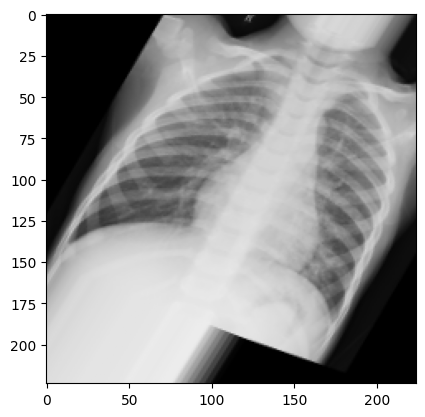

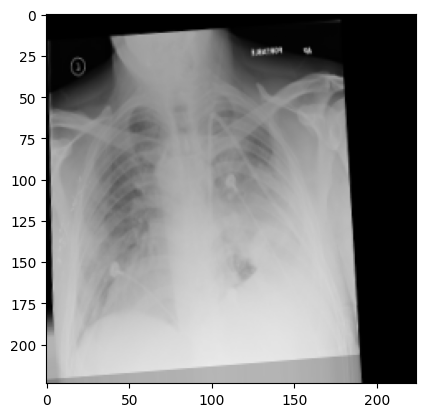

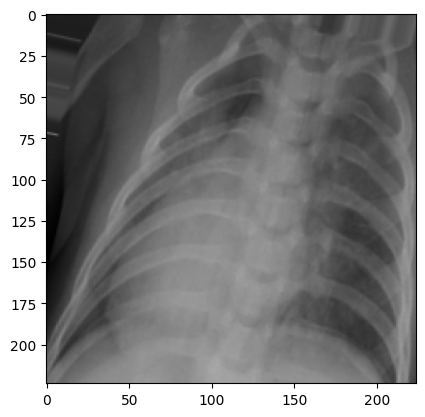

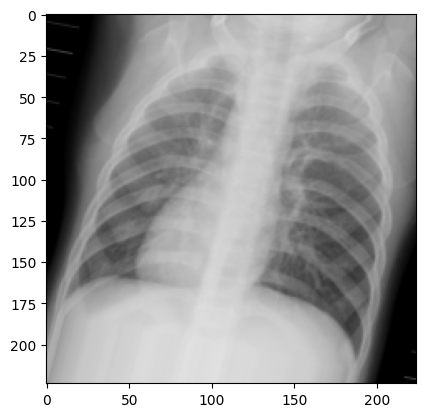

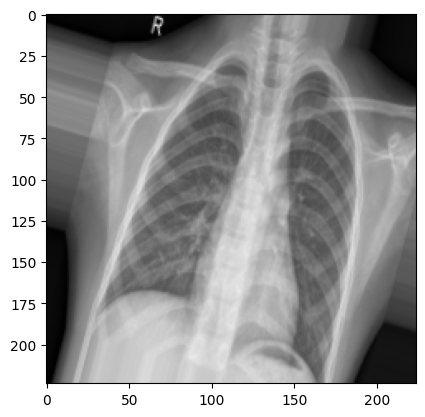

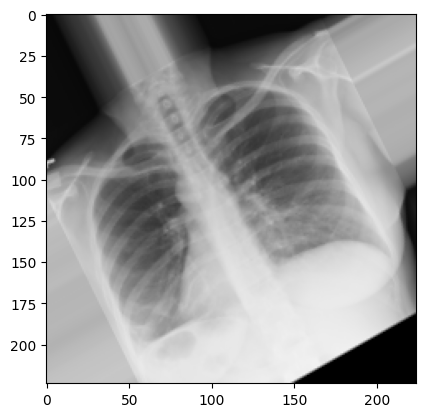

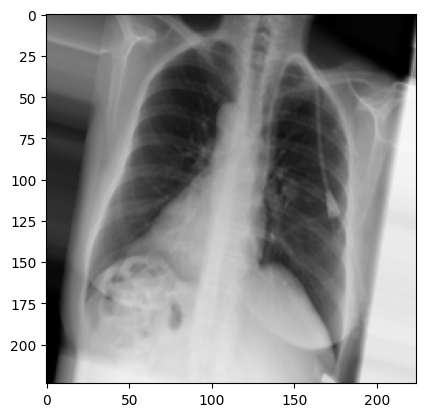

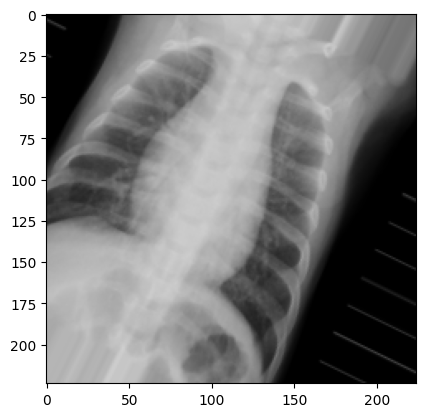

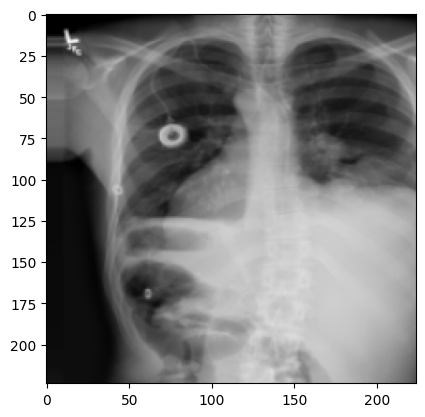

In [8]:
dataset_subset = train_dataset.take(1)

# Select the pixel columns (modify if your column names are different)
labels = []
pixels = []
for image, label in dataset_subset:
    labels.append(label.numpy())
    pixels.append(image.numpy())

labels = np.array(labels)
pixels = np.array(pixels)  # Shape: (10, dimension, dimension, channels)
# Reshape data to the original image shape
pixels = pixels.reshape(-1, dimension, dimension, channels)

# Create the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range = 30,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False
)
i = 0
for batch in datagen.flow(pixels, batch_size=1):
    plt.figure(i)
    plt.imshow(batch[0].reshape(dimension, dimension, channels))
    
    i += 1
    if i % 10 == 0:
        break

plt.show()

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
Physical devices cannot be modified after being initialized


Model training

In [12]:
tf.keras.backend.clear_session()

logs= "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# tf.profiler.experimental.start('./logs/profile')

base_model = MobileNetV2(input_shape=(dimension, dimension, channels), include_top=False, weights='imagenet')

data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

inputs = tf.keras.Input(shape=(dimension, dimension, channels))
x = data_augmentation(inputs)  # Data augmentation directly applied to inputs
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer= Adam(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics = ['accuracy',
                            BinaryAccuracy(threshold=0.25, name='binary_accuracy'),
                            FalsePositives(name='fp'),
                            FalseNegatives(name='fn'),
                            TrueNegatives(name='tn'),
                            TruePositives(name='tp'),
                            MeanSquaredError(name='Brier score'),
                            Precision(name='precision'),
                            Recall(name='recall'),
                            AUC(name='auc'),
                            AUC(name='prc', curve='PR') # precision-recall curve
                ])          

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',  # Metric
                                            patience=2,             # Number of epochs with no improvement
                                            verbose=1,              # Log output
                                            factor=0.3,             # Factor by which the learning rate will be reduced
                                            min_lr=1e-7)         # Minimum learning rate

earlystop = EarlyStopping(monitor="val_prc", 
                          verbose=1, 
                          mode="auto", 
                          patience=3,
                          restore_best_weights=True)


tensorboard = TensorBoard(log_dir=logs, 
                          profile_batch='10, 15', 
                          write_graph=True, 
                          histogram_freq = 1)

backup = BackupAndRestore(backup_dir = "./backup")

terminate = TerminateOnNaN()

history = model.fit(train_dataset, batch_size=batch_size,
                    epochs=initial_epochs,
                    verbose="auto",
                    validation_data= val_dataset,
                    callbacks=[learning_rate_reduction, tensorboard, backup, terminate, earlystop],
                    shuffle=True)
                     
model.evaluate(test_dataset)
# tf.profiler.experimental.stop()

Epoch 1/25


2024-12-27 10:19:00.252498: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2024-12-27 10:19:00.252561: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2024-12-27 10:19:00.255884: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:151] cuptiGetTimestamp: ignored due to a previous error.
2024-12-27 10:19:00.255968: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:206] cuptiSubscribe: ignored due to a previous error.
2024-12-27 10:19:00.255983: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:243] cuptiGetResultString: ignored due to a previous error.
2024-12-27 10:19:00.256401: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1112] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-12-27 10:19:00.257248: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130]

      9/Unknown 37s 300ms/step - Brier score: 0.2358 - accuracy: 0.6663 - auc: 0.4191 - binary_accuracy: 0.7340 - fn: 5.4444 - fp: 20.2222 - loss: 7.9685 - prc: 0.6828 - precision: 0.7245 - recall: 0.8813 - tn: 1.0000 - tp: 53.3333

2024-12-27 10:19:37.119174: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2024-12-27 10:19:37.119221: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2024-12-27 10:19:37.119250: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:151] cuptiGetTimestamp: ignored due to a previous error.
2024-12-27 10:19:37.119257: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:206] cuptiSubscribe: ignored due to a previous error.
2024-12-27 10:19:37.119261: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:243] cuptiGetResultString: ignored due to a previous error.
2024-12-27 10:19:37.119265: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1112] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 


     14/Unknown 38s 303ms/step - Brier score: 0.2245 - accuracy: 0.6843 - auc: 0.4657 - binary_accuracy: 0.7356 - fn: 6.0000 - fp: 29.8571 - loss: 7.9223 - prc: 0.7162 - precision: 0.7300 - recall: 0.9058 - tn: 1.7857 - tp: 82.3571

2024-12-27 10:19:39.395499: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:68] Profiler session collecting data.
2024-12-27 10:19:39.443978: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:158] cuptiFinalize: ignored due to a previous error.
2024-12-27 10:19:39.444069: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:243] cuptiGetResultString: ignored due to a previous error.
2024-12-27 10:19:39.444082: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1222] function cupti_interface_->Finalize()failed with error 
2024-12-27 10:19:39.444092: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:151] cuptiGetTimestamp: ignored due to a previous error.
2024-12-27 10:19:39.652850: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:151] cuptiGetTimestamp: ignored due to a previous error.
2024-12-27 10:19:39.652992: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:635]  GpuT

     15/Unknown 40s 374ms/step - Brier score: 0.2230 - accuracy: 0.6864 - auc: 0.4747 - binary_accuracy: 0.7346 - fn: 6.1333 - fp: 31.8667 - loss: 7.9152 - prc: 0.7205 - precision: 0.7301 - recall: 0.9090 - tn: 2.2000 - tp: 87.8000

2024-12-27 10:19:39.856625: I external/local_xla/xla/tsl/profiler/rpc/client/save_profile.cc:147] Collecting XSpace to repository: ./logs/20241227-101858/train/plugins/profile/2024_12_27_10_19_39/DESKTOP-NI79KGR.xplane.pb


    697/Unknown 245s 302ms/step - Brier score: 0.1301 - accuracy: 0.8176 - auc: 0.8256 - binary_accuracy: 0.8092 - fn: 258.1420 - fp: 708.0660 - loss: 5.6232 - prc: 0.9265 - precision: 0.8394 - recall: 0.9372 - tn: 673.8494 - tp: 3943.9412

2024-12-27 10:23:04.996173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18038257945641575531
2024-12-27 10:23:04.996255: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14301033764276986120
2024-12-27 10:23:04.996271: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6599539181186285326
2024-12-27 10:23:50.658949: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157286400 exceeds 10% of free system memory.


697/697 ━━━━━━━━━━━━━━━━━━━━ 291s 369ms/step - Brier score: 0.1301 - accuracy: 0.8176 - auc: 0.8256 - binary_accuracy: 0.8092 - fn: 258.4785 - fp: 709.0157 - loss: 5.6210 - prc: 0.9265 - precision: 0.8394 - recall: 0.9373 - tn: 674.8582 - tp: 3949.6218 - val_Brier score: 0.2452 - val_accuracy: 0.7535 - val_auc: 0.5530 - val_binary_accuracy: 0.7535 - val_fn: 0.0000e+00 - val_fp: 2749.0000 - val_loss: 3.4608 - val_prc: 0.7739 - val_precision: 0.7535 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8402.0000 - learning_rate: 1.0000e-04
Epoch 2/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - Brier score: 0.1053 - accuracy: 0.8522 - auc: 0.8909 - binary_accuracy: 0.8386 - fn: 210.9469 - fp: 599.5911 - loss: 1.4721 - prc: 0.9591 - precision: 0.8666 - recall: 0.9509 - tn: 775.3257 - tp: 3998.1348

2024-12-27 10:27:18.735130: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5518637443567630126
2024-12-27 10:27:18.735207: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7288215241446308297
2024-12-27 10:27:18.735258: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15943091182959776407
2024-12-27 10:27:18.735274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18038257945641575531
2024-12-27 10:27:18.735278: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 1675180018704942319
2024-12-27 10:27:18.735287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14301033764276986120
2024-12-27 10:27:18.735291: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send 

697/697 ━━━━━━━━━━━━━━━━━━━━ 250s 357ms/step - Brier score: 0.1053 - accuracy: 0.8522 - auc: 0.8909 - binary_accuracy: 0.8386 - fn: 211.2493 - fp: 600.4169 - loss: 1.4717 - prc: 0.9591 - precision: 0.8666 - recall: 0.9509 - tn: 776.4685 - tp: 4003.8396 - val_Brier score: 0.2402 - val_accuracy: 0.7541 - val_auc: 0.6730 - val_binary_accuracy: 0.7537 - val_fn: 0.0000e+00 - val_fp: 2742.0000 - val_loss: 1.8151 - val_prc: 0.8271 - val_precision: 0.7539 - val_recall: 1.0000 - val_tn: 7.0000 - val_tp: 8402.0000 - learning_rate: 1.0000e-04
Epoch 3/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - Brier score: 0.0928 - accuracy: 0.8665 - auc: 0.9208 - binary_accuracy: 0.8498 - fn: 237.6356 - fp: 518.8666 - loss: 0.5787 - prc: 0.9718 - precision: 0.8856 - recall: 0.9458 - tn: 851.9326 - tp: 3975.5640

2024-12-27 10:31:33.734087: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5518637443567630126
2024-12-27 10:31:33.734176: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14301033764276986120
2024-12-27 10:31:33.734210: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17746439330873210086
2024-12-27 10:31:33.734220: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7288215241446308297
2024-12-27 10:31:33.734267: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15943091182959776407
2024-12-27 10:31:33.734303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6599539181186285326
2024-12-27 10:31:33.734347: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

697/697 ━━━━━━━━━━━━━━━━━━━━ 257s 367ms/step - Brier score: 0.0928 - accuracy: 0.8665 - auc: 0.9208 - binary_accuracy: 0.8498 - fn: 237.9900 - fp: 519.5831 - loss: 0.5786 - prc: 0.9718 - precision: 0.8856 - recall: 0.9458 - tn: 853.1906 - tp: 3981.2107 - val_Brier score: 0.2246 - val_accuracy: 0.7645 - val_auc: 0.7178 - val_binary_accuracy: 0.7592 - val_fn: 0.0000e+00 - val_fp: 2626.0000 - val_loss: 1.5279 - val_prc: 0.8453 - val_precision: 0.7619 - val_recall: 1.0000 - val_tn: 123.0000 - val_tp: 8402.0000 - learning_rate: 1.0000e-04
Epoch 4/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - Brier score: 0.0848 - accuracy: 0.8815 - auc: 0.9326 - binary_accuracy: 0.8639 - fn: 229.7547 - fp: 453.9469 - loss: 0.3500 - prc: 0.9765 - precision: 0.9019 - recall: 0.9465 - tn: 915.3716 - tp: 3984.9253

2024-12-27 10:35:44.515719: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7288215241446308297
2024-12-27 10:35:44.515813: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15943091182959776407
2024-12-27 10:35:44.515834: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5518637443567630126
2024-12-27 10:35:44.515889: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18038257945641575531
2024-12-27 10:35:44.515922: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 1675180018704942319
2024-12-27 10:35:44.515933: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14301033764276986120
2024-12-27 10:35:44.515954: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send 

697/697 ━━━━━━━━━━━━━━━━━━━━ 248s 355ms/step - Brier score: 0.0848 - accuracy: 0.8815 - auc: 0.9326 - binary_accuracy: 0.8638 - fn: 230.0831 - fp: 454.6246 - loss: 0.3500 - prc: 0.9765 - precision: 0.9019 - recall: 0.9465 - tn: 916.6705 - tp: 3990.5959 - val_Brier score: 0.1560 - val_accuracy: 0.8199 - val_auc: 0.8820 - val_binary_accuracy: 0.8035 - val_fn: 5.0000 - val_fp: 2003.0000 - val_loss: 0.7296 - val_prc: 0.9346 - val_precision: 0.8074 - val_recall: 0.9994 - val_tn: 746.0000 - val_tp: 8397.0000 - learning_rate: 1.0000e-04
Epoch 5/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - Brier score: 0.0818 - accuracy: 0.8849 - auc: 0.9393 - binary_accuracy: 0.8605 - fn: 217.9297 - fp: 419.3228 - loss: 0.2896 - prc: 0.9782 - precision: 0.9036 - recall: 0.9485 - tn: 958.8981 - tp: 3987.8479

2024-12-27 10:39:52.388085: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5518637443567630126
2024-12-27 10:39:52.388163: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7288215241446308297
2024-12-27 10:39:52.388176: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15943091182959776407
2024-12-27 10:39:52.388187: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18038257945641575531
2024-12-27 10:39:52.388191: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 1675180018704942319
2024-12-27 10:39:52.388200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14301033764276986120
2024-12-27 10:39:52.388205: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send 

697/697 ━━━━━━━━━━━━━━━━━━━━ 248s 354ms/step - Brier score: 0.0818 - accuracy: 0.8849 - auc: 0.9393 - binary_accuracy: 0.8605 - fn: 218.2478 - fp: 419.9155 - loss: 0.2896 - prc: 0.9782 - precision: 0.9036 - recall: 0.9485 - tn: 960.2693 - tp: 3993.5415 - val_Brier score: 0.1421 - val_accuracy: 0.8205 - val_auc: 0.9011 - val_binary_accuracy: 0.7922 - val_fn: 137.0000 - val_fp: 1865.0000 - val_loss: 0.5290 - val_prc: 0.9582 - val_precision: 0.8159 - val_recall: 0.9837 - val_tn: 884.0000 - val_tp: 8265.0000 - learning_rate: 1.0000e-04
Epoch 6/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - Brier score: 0.0761 - accuracy: 0.8932 - auc: 0.9440 - binary_accuracy: 0.8753 - fn: 196.2123 - fp: 398.1392 - loss: 0.2610 - prc: 0.9794 - precision: 0.9102 - recall: 0.9527 - tn: 975.1349 - tp: 4014.5122

2024-12-27 10:44:05.565696: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5518637443567630126
2024-12-27 10:44:05.565779: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7288215241446308297
2024-12-27 10:44:05.565791: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15943091182959776407
2024-12-27 10:44:05.565804: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18038257945641575531
2024-12-27 10:44:05.565808: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 1675180018704942319
2024-12-27 10:44:05.565818: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14301033764276986120
2024-12-27 10:44:05.565822: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send 

697/697 ━━━━━━━━━━━━━━━━━━━━ 253s 362ms/step - Brier score: 0.0761 - accuracy: 0.8932 - auc: 0.9440 - binary_accuracy: 0.8753 - fn: 196.4885 - fp: 398.6848 - loss: 0.2610 - prc: 0.9794 - precision: 0.9102 - recall: 0.9527 - tn: 976.5602 - tp: 4020.2407 - val_Brier score: 0.1420 - val_accuracy: 0.8215 - val_auc: 0.9227 - val_binary_accuracy: 0.7866 - val_fn: 43.0000 - val_fp: 1947.0000 - val_loss: 0.5215 - val_prc: 0.9694 - val_precision: 0.8111 - val_recall: 0.9949 - val_tn: 802.0000 - val_tp: 8359.0000 - learning_rate: 1.0000e-04
Epoch 7/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - Brier score: 0.0743 - accuracy: 0.8970 - auc: 0.9456 - binary_accuracy: 0.8799 - fn: 190.8092 - fp: 380.6801 - loss: 0.2527 - prc: 0.9797 - precision: 0.9119 - recall: 0.9559 - tn: 994.3917 - tp: 4018.1177

2024-12-27 10:48:14.464150: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7288215241446308297
2024-12-27 10:48:14.464232: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15943091182959776407
2024-12-27 10:48:14.464272: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5518637443567630126
2024-12-27 10:48:14.464322: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18038257945641575531
2024-12-27 10:48:14.464356: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 1675180018704942319
2024-12-27 10:48:14.464394: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14301033764276986120
2024-12-27 10:48:14.464407: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send 

697/697 ━━━━━━━━━━━━━━━━━━━━ 248s 355ms/step - Brier score: 0.0743 - accuracy: 0.8970 - auc: 0.9456 - binary_accuracy: 0.8799 - fn: 191.0731 - fp: 381.2249 - loss: 0.2527 - prc: 0.9797 - precision: 0.9119 - recall: 0.9559 - tn: 995.8152 - tp: 4023.8611 - val_Brier score: 0.0895 - val_accuracy: 0.8755 - val_auc: 0.9328 - val_binary_accuracy: 0.8536 - val_fn: 395.0000 - val_fp: 993.0000 - val_loss: 0.2938 - val_prc: 0.9772 - val_precision: 0.8897 - val_recall: 0.9530 - val_tn: 1756.0000 - val_tp: 8007.0000 - learning_rate: 1.0000e-04
Epoch 8/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - Brier score: 0.0709 - accuracy: 0.9019 - auc: 0.9524 - binary_accuracy: 0.8821 - fn: 187.1263 - fp: 356.5983 - loss: 0.2387 - prc: 0.9825 - precision: 0.9168 - recall: 0.9561 - tn: 1023.0703 - tp: 4017.2036

2024-12-27 10:52:25.662393: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5518637443567630126
2024-12-27 10:52:25.662481: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14301033764276986120
2024-12-27 10:52:25.662515: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17746439330873210086
2024-12-27 10:52:25.662528: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7288215241446308297
2024-12-27 10:52:25.662574: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15943091182959776407
2024-12-27 10:52:25.662614: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6599539181186285326
2024-12-27 10:52:25.662658: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

697/697 ━━━━━━━━━━━━━━━━━━━━ 251s 359ms/step - Brier score: 0.0709 - accuracy: 0.9019 - auc: 0.9524 - binary_accuracy: 0.8821 - fn: 187.3911 - fp: 357.0817 - loss: 0.2387 - prc: 0.9825 - precision: 0.9168 - recall: 0.9561 - tn: 1024.5487 - tp: 4022.9526 - val_Brier score: 0.1221 - val_accuracy: 0.8310 - val_auc: 0.9019 - val_binary_accuracy: 0.8421 - val_fn: 1283.0000 - val_fp: 601.0000 - val_loss: 0.3936 - val_prc: 0.9673 - val_precision: 0.9222 - val_recall: 0.8473 - val_tn: 2148.0000 - val_tp: 7119.0000 - learning_rate: 1.0000e-04
Epoch 9/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - Brier score: 0.0678 - accuracy: 0.9068 - auc: 0.9563 - binary_accuracy: 0.8879 - fn: 181.7174 - fp: 332.9799 - loss: 0.2279 - prc: 0.9847 - precision: 0.9220 - recall: 0.9576 - tn: 1044.4404 - tp: 4024.8608
Epoch 9: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.


2024-12-27 10:57:14.576681: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18271883360169279985
2024-12-27 10:57:14.577064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11750864379166813708
2024-12-27 10:57:14.577090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1182538374816558596


697/697 ━━━━━━━━━━━━━━━━━━━━ 250s 357ms/step - Brier score: 0.0678 - accuracy: 0.9068 - auc: 0.9563 - binary_accuracy: 0.8879 - fn: 181.9914 - fp: 333.4642 - loss: 0.2279 - prc: 0.9847 - precision: 0.9220 - recall: 0.9576 - tn: 1045.9211 - tp: 4030.5974 - val_Brier score: 0.2125 - val_accuracy: 0.7407 - val_auc: 0.9015 - val_binary_accuracy: 0.7853 - val_fn: 2767.0000 - val_fp: 125.0000 - val_loss: 0.8928 - val_prc: 0.9685 - val_precision: 0.9783 - val_recall: 0.6707 - val_tn: 2624.0000 - val_tp: 5635.0000 - learning_rate: 1.0000e-04
Epoch 10/25
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - Brier score: 0.0548 - accuracy: 0.9276 - auc: 0.9703 - binary_accuracy: 0.9103 - fn: 136.1205 - fp: 275.2525 - loss: 0.1896 - prc: 0.9892 - precision: 0.9373 - recall: 0.9690 - tn: 1098.0688 - tp: 4074.5566

2024-12-27 11:00:47.367670: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5518637443567630126
2024-12-27 11:00:47.367754: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7288215241446308297
2024-12-27 11:00:47.367766: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15943091182959776407
2024-12-27 11:00:47.367778: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18038257945641575531
2024-12-27 11:00:47.367782: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 1675180018704942319
2024-12-27 11:00:47.367791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14301033764276986120
2024-12-27 11:00:47.367796: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send 

697/697 ━━━━━━━━━━━━━━━━━━━━ 252s 360ms/step - Brier score: 0.0548 - accuracy: 0.9276 - auc: 0.9703 - binary_accuracy: 0.9103 - fn: 136.3453 - fp: 275.6719 - loss: 0.1896 - prc: 0.9892 - precision: 0.9372 - recall: 0.9690 - tn: 1099.6204 - tp: 4080.3367 - val_Brier score: 0.1901 - val_accuracy: 0.7516 - val_auc: 0.9177 - val_binary_accuracy: 0.8042 - val_fn: 2660.0000 - val_fp: 110.0000 - val_loss: 0.6608 - val_prc: 0.9732 - val_precision: 0.9812 - val_recall: 0.6834 - val_tn: 2639.0000 - val_tp: 5742.0000 - learning_rate: 3.0000e-05
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.
697/697 ━━━━━━━━━━━━━━━━━━━━ 46s 65ms/step - Brier score: 0.0899 - accuracy: 0.8753 - auc: 0.9311 - binary_accuracy: 0.8520 - fn: 205.3438 - fp: 494.5831 - loss: 0.2958 - prc: 0.9769 - precision: 0.8913 - recall: 0.9509 - tn: 883.1963 - tp: 4008.8511


2024-12-27 11:02:16.505453: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18271883360169279985
2024-12-27 11:02:16.505519: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11750864379166813708
2024-12-27 11:02:16.505532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1182538374816558596


[0.29382655024528503,
 0.8755268454551697,
 0.853645384311676,
 993.0,
 395.0,
 1756.0,
 8007.0,
 0.08945603668689728,
 0.8896666765213013,
 0.9529873728752136,
 0.932794988155365,
 0.9772408604621887]

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,674,885 (33.09 MB)

 Trainable params: 2,880,257 (10.99 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 5,760,516 (21.97 MB)

In [14]:
%load_ext tensorboard
%tensorboard --logdir ./logs/ --load_fast=false --verbosity 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

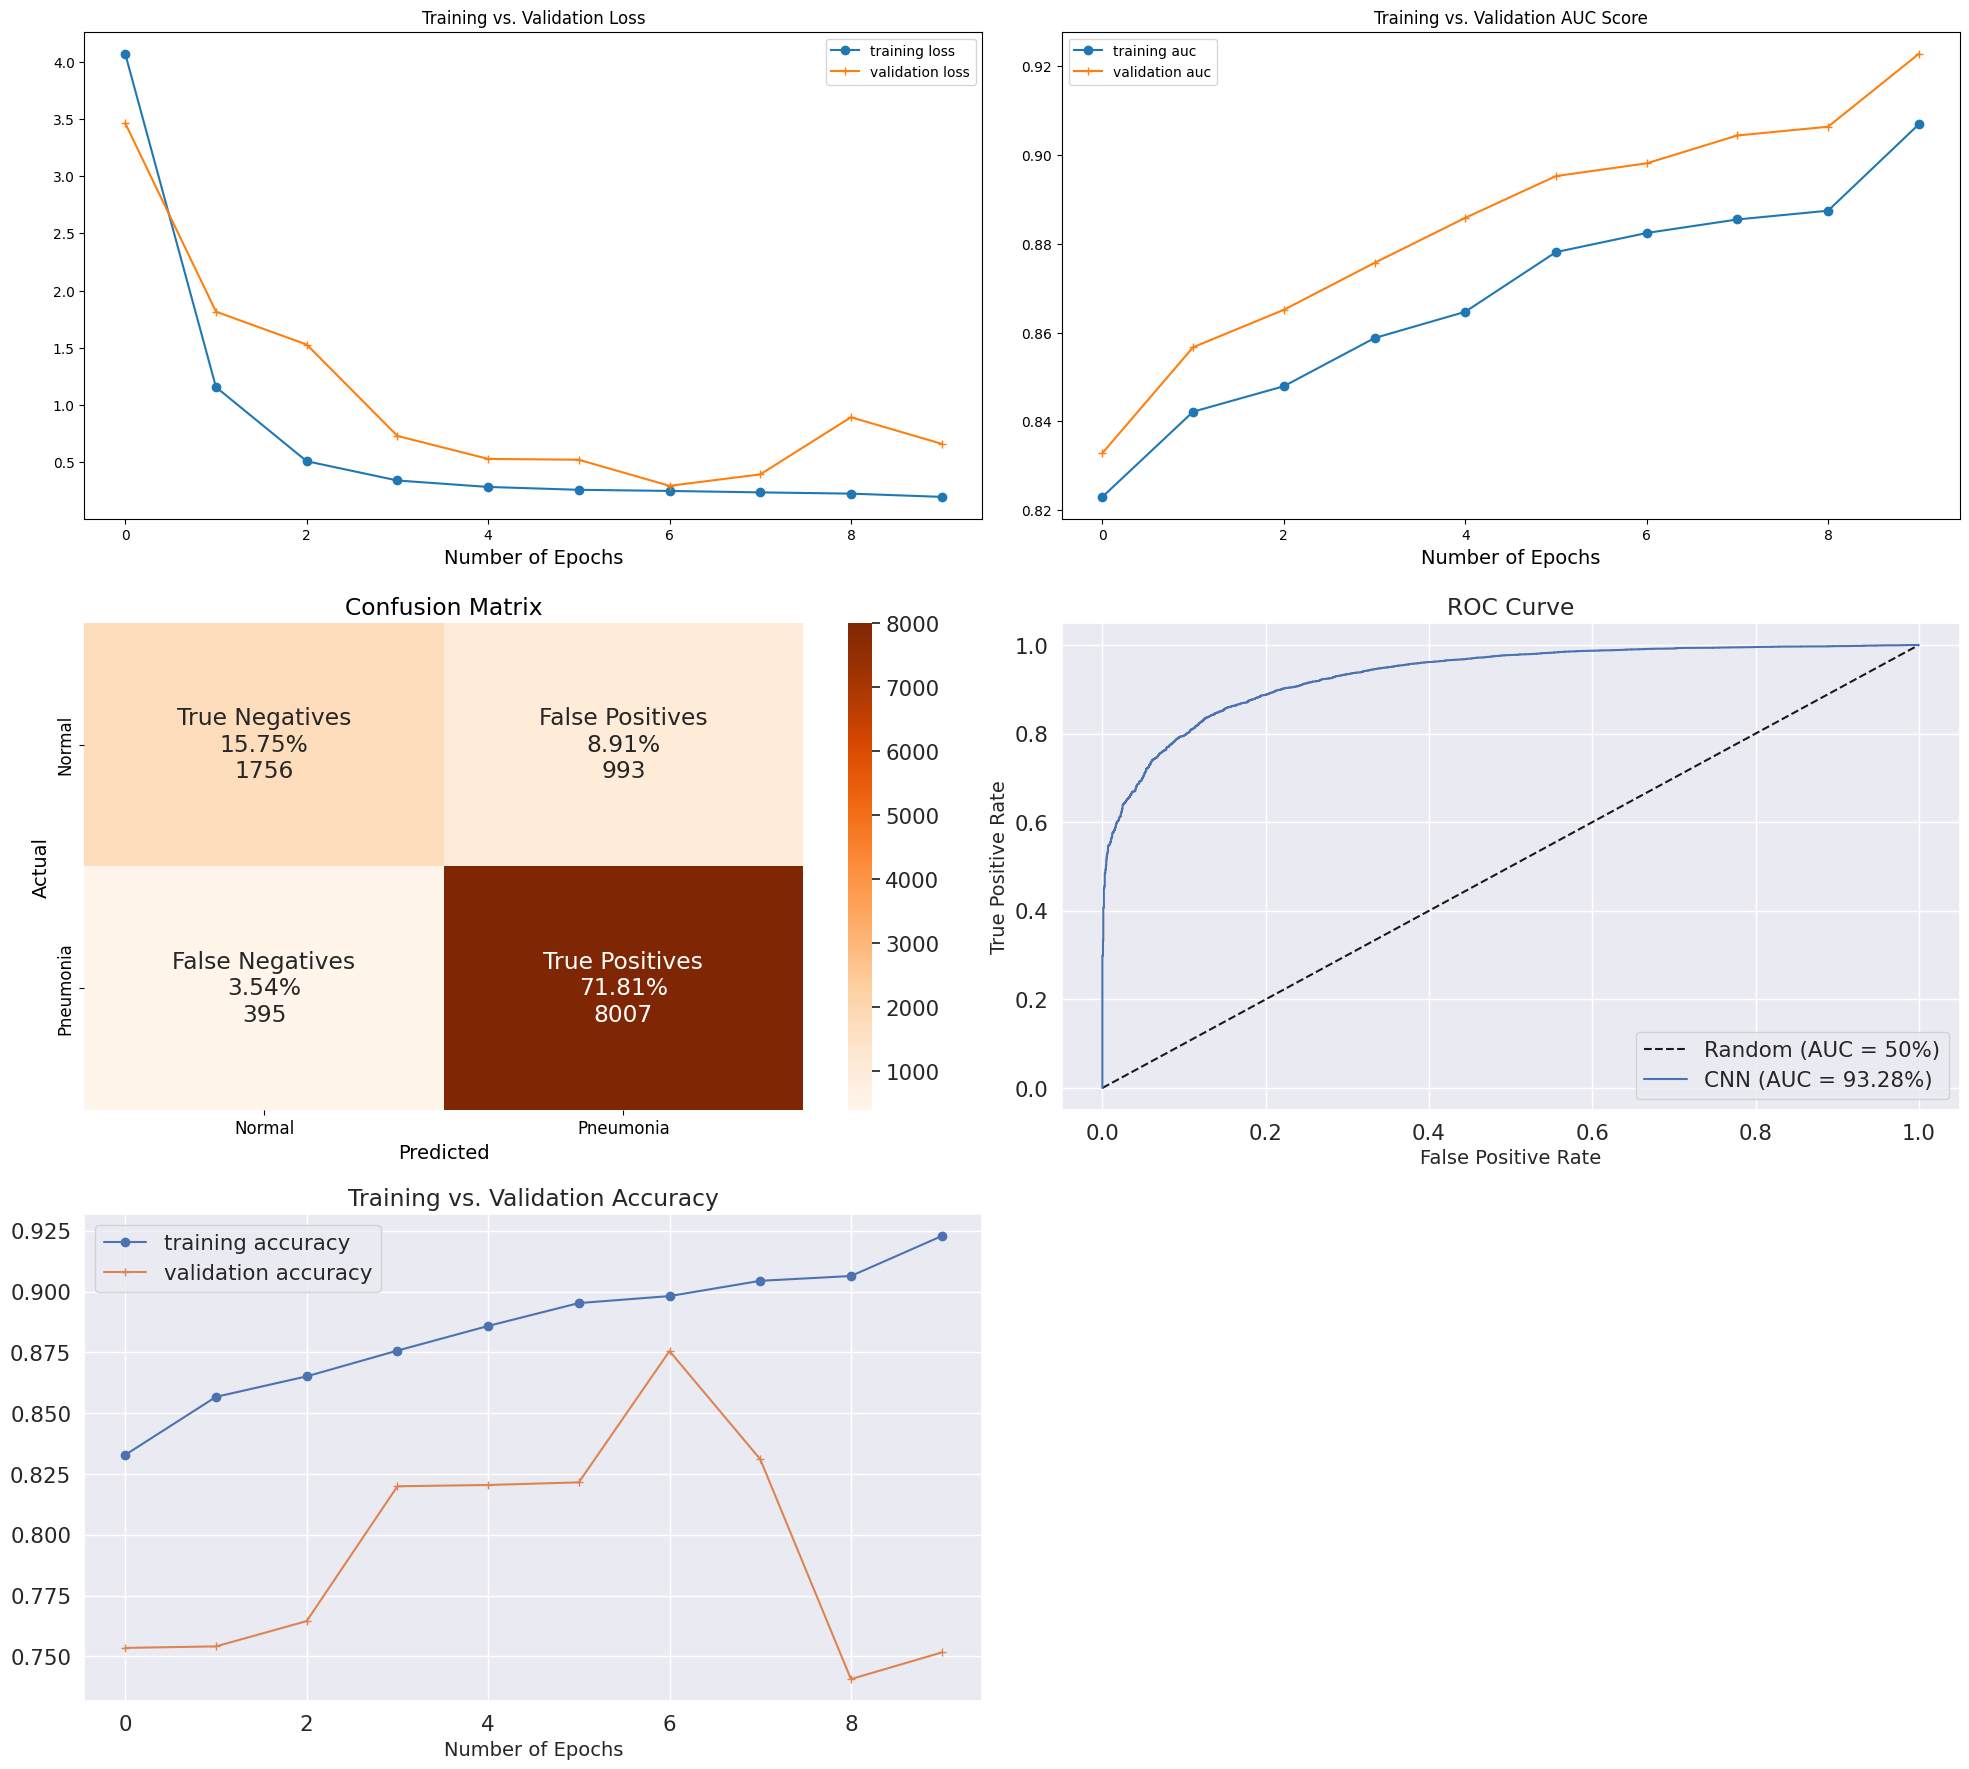

In [15]:
dataset = load_tfrecord('data.tfrecord', batch_size=batch_size)

create_charts(model, history, dataset)

In [16]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)